In [96]:
from langgraph.graph import StateGraph, START , END
from dotenv import load_dotenv
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langchain_core.messages.base import BaseMessage
import os

from rich.console import Console
from rich.panel import Panel

load_dotenv()
llm=ChatGoogleGenerativeAI(model=os.getenv("MODEL_NAME"))

console = Console()

def print_ai_response(response, title="🤖 AI Response"):
    console.print(
        Panel(
            response if isinstance(response, str) else repr(response),
            title=title,
            border_style="green",
            expand=True,
        )
    )

def print_user_input(user_input, title="👤 User Input"):
    console.print(
        Panel(
            user_input,
            title=title,
            border_style="blue",
            expand=True,
        )
    )

def print_tool_call(tool_call, title="🔧 Tool Call"):
    """Print tool call information. Accepts either a dict with 'name' and 'args' or a string message."""
    if isinstance(tool_call, str):
        # If it's a string, just print it
        content = tool_call
    elif isinstance(tool_call, dict):
        # If it's a dict, format it
        content = f"Tool: {tool_call.get('name', 'Unknown')}\nArgs: {tool_call.get('args', {})}"
    else:
        # Fallback: convert to string
        content = str(tool_call)
    
    console.print(
        Panel(
            content,
            title=title,
            border_style="yellow",
            expand=True,
        )
    )

def print_step(title, content):
    console.print(
        Panel(
            content,
            title=title,
            border_style="cyan",
            expand=True,
        )
    )

def format_messages(messages):
    formatted = []
    for msg in messages:
        role = msg.__class__.__name__.replace("Message", "")
        formatted.append(f"[bold]{role}:[/bold]\n{msg.content}")
    return "\n\n".join(formatted)

In [97]:
# global variable for document content
document_content = ""

In [98]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage] , add_messages]

In [ ]:
@tool
def update(content:str) -> str:
    """Update the document content"""
    global document_content
    document_content = content
    print(f"Tools update: Document updated with content: {content}")
    return f"Document updated with content: {content}"

@tool
def save(fileName:str) -> str:
    """Save the document content to a file.
    IMPORTANT: Only call this tool AFTER the document has been updated using the update tool.
    Args:
        fileName: name of text file
    Returns:
        A message indicating the document has been saved
    """
    
    global document_content

    # Check if document_content is empty
    if not document_content or document_content.strip() == "":
        error_msg = "ERROR: Cannot save empty document. Please use the update tool first to set the document content before saving."
        print(f"Tools save: {error_msg}")
        return error_msg

    if not fileName.endswith('.txt'):
       fileName = fileName + '.txt'

    try:
        with open(fileName, 'w', encoding='utf-8') as f:
            f.write(document_content)
        
        print(f"Tools save: Document saved to {fileName} with {len(document_content)} characters")
        return f"Document saved to {fileName} successfully. Content length: {len(document_content)} characters"
    except Exception as e:
        print(f"Error saving document: {e}")
        return f"Error saving document: {e}"
   
   

In [100]:
tools = [update, save]

# bind tools model
model = llm.bind_tools(tools)

my_tools = ToolNode(tools)

In [101]:

    


def agent(state:AgentState) -> AgentState:
    # Create system instruction with current document content
    # For Google Gemini, we need to use system_instruction parameter instead of SystemMessage
    system_instruction = f"""
            You are an Email Drafter assistant.

            Your responsibilities:
            - Help the user write, rewrite, or edit email content.
            - Maintain the original meaning unless the user explicitly asks to change it.

            Document rules:
            - Only update the document when the user explicitly asks to modify, rewrite, or edit the document.
            - If the user asks a question, gives feedback, or asks for suggestions, do NOT update the document.
            - When updating, always produce the full updated document content (not partial diffs).
            - Preserve any content that the user did not request to change.

            Tool usage rules:
            - If the user requests to update or modify the document, use the update tool with the complete updated content.
            - If the user requests to save the document, use the save tool with the provided file name.
            - CRITICAL: You MUST call the update tool BEFORE calling the save tool. Never call save without first updating the document content.
            - Never call tools unless the user intent clearly requires it.

            Interaction & guidance rules:
            - If you suggest edits but the user has not explicitly asked to update, present the suggested content and ask whether they want you to apply the changes.
            - After a document has been updated, ask the user whether they want to save the document.
            - If the user's request is ambiguous (e.g. "make it better"), ask a clarifying question before updating.

            After any document update:
            - Always display the full current document content to the user.

            Current document content:
            {document_content}
        """
    
    if not state['messages']:
        user_input = input("Please provide the email content to draft: ")
        print(f"Function agent: User input {user_input}")
        user_message = HumanMessage(content=user_input)
        
    else:
       user_input = input(f"What would you like to do next, with the current document content: {document_content}")
       print(f"Function agent: User input {user_input}")

       user_message = HumanMessage(content=user_input)

    # Bind system_instruction to model for Google Gemini (this is the correct way)
    # Don't add SystemMessage to state messages - it causes rendering errors
    all_messages = list(state['messages']) + [user_message]
    print_user_input(user_input)  # Print only the user input, not all messages

    # Use bind to add system_instruction
    model_with_system = model.bind(system_instruction=system_instruction)
    response = model_with_system.invoke(all_messages)

    print_ai_response(response.content if hasattr(response, 'content') else str(response))

    if hasattr(response, 'tool_calls') and response.tool_calls:
        print("Invoking tools...:")
        for tool_call in response.tool_calls:
            tool_name = tool_call['name']
            tool_args = tool_call['args']
            print(f"Invoking tool: {tool_name} with args: {tool_args}")
                

    return {'messages': list(state['messages']) + [user_message, response]}


def should_continue(state:AgentState) -> str:

    messages = state['messages']

    if not messages:
        return 'continue'
    
    for message in reversed(messages):
        # end the loop only if save tool is used
        if hasattr(message, 'tool_calls') and message.tool_calls:
            # Check if any tool call is the 'save' tool
            for tool_call in message.tool_calls:
                # For Google Gemini, tool_calls are dictionaries with 'name' and 'args' keys
                tool_name = tool_call['name'] if isinstance(tool_call, dict) else tool_call.get('name', '')
                if tool_name == 'save':
                    return 'end'
            # If other tools are used, continue the loop
            return 'continue'

        # end the loop if user input is empty
        if isinstance(message, HumanMessage) and not message.content:
            return 'end'

    return 'continue'
    

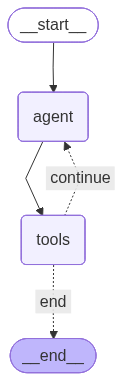

In [102]:
graph = StateGraph(AgentState)
graph.add_node("agent", agent)
graph.add_node('tools', my_tools)

# start
graph.add_edge(START, "agent")
graph.add_edge("agent", "tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        'continue': "agent",
        'end': END
    }
)

bot = graph.compile()

bot

In [103]:
def run_document_agent():
    """Run the document agent"""

    state={'messages': []}
    
    for step in bot.stream(state):
        if "messages" in step:
            content = format_messages(step["messages"])
            print_step(
                title="🧠 Agent step",
                content=content,
                color="green"
            )

    print("Conversation ended")

In [104]:
run_document_agent()

Function agent: User input email xin việc


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ email xin việc                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': 'Chắc chắn rồi, đây là một mẫu email xin việc bạn có thể tham khảo:\n\nSubject: Ứng   │
│ tuyển vị trí [Tên vị trí ứng tuyển] - [Tên của bạn]\n\nKính gửi Ông/Bà [Tên người quản lý tuyển dụng hoặc Phòng │
│ ban tuyển dụng, nếu biết],\n\nTôi viết email này để bày tỏ sự quan tâm sâu sắc của mình đến vị trí [Tên vị trí  │
│ ứng tuyển] mà quý công ty đang tuyển dụng, được đăng tải trên [Nguồn bạn thấy tin tuyển dụng, ví dụ: LinkedIn,  │
│ VietnamWorks, website công ty].\n\nVới [Số năm] năm kinh nghiệm trong lĩnh vực [Lĩnh vực của bạn] và chuyên môn │
│ về [Kỹ năng/Lĩnh vực chuyên môn nổi bật nhất của bạn, ví dụ: phát triển phần mềm, marketing số, quản lý dự án], │
│ tôi tin rằng mình có đủ năng lực và kinh nghiệm để đóng góp vào sự phát triển của quý công ty. Trong các vai    │
│ trò trước đây, tôi đã đạt được những thành tựu đáng kể như [Nêu 1-2 thành tựu nổi bật và cụ thể nhất, có thể    │
│ định lượng nếu có].\n\nTôi rất ấn tượng với [Nêu một điểm cụ thể bạn thích về công ty, ví dụ: văn hóa doanh     │
│ nghiệp, sản phẩm/dịch vụ, dự án tiêu biểu] của quý công ty và tin rằng môi trường làm việc tại đây sẽ là nơi lý │
│ tưởng để tôi phát huy tối đa khả năng của mình.\n\nTôi đã đính kèm sơ yếu lý lịch (CV) và thư xin việc (Cover   │
│ Letter) chi tiết để quý công ty có thể xem xét. Tôi rất mong có cơ hội được trình bày rõ hơn về kinh nghiệm và  │
│ kỹ năng của mình trong một buổi phỏng vấn trực tiếp.\n\nChân thành cảm ơn quý công ty đã dành thời gian xem xét │
│ hồ sơ của tôi.\n\nTrân trọng,\n\n[Tên của bạn]\n[Số điện thoại của bạn]\n[Địa chỉ email của bạn]\n[Link         │
│ LinkedIn của bạn (nếu có)]\n[Link Portfolio/Website cá nhân (nếu có)]\n\nBạn có muốn tôi giúp bạn chỉnh sửa     │
│ hoặc lưu email này vào một tệp không?', 'extras': {'signature':                                                 │
│ 'CsADAXLI2nym6yN3v5Rz42RhZys4DK17GpmQeFqo01eqTu3nJR+AahLw5urf3hJR4T3X2V1IEBx30YKCBFTOR0qELCphy9GN298085junsMcU9 │
│ JAMTo1G5VoJmy9CIZpQmv9mYbyyFEM/78RXtx5T7yPZomNBAeC8exKTvbQm5ZqMzTiQfMSCr5eQqYA0gwclEKzypaJ7ZJkfuZ/NeXyU/OwGpOkF │
│ btEheblBJw67pd7/Ak3k6p0iCLKQJAC4aL5cQMdvNXz2b6ci3p09sFpD3C1Bubi+/qm7/+BjpmcPkCKaL6TkKnUsyXqoG0e3AcoCjPWcap7pe+R │
│ wtkTS805ijIxjV4RPN6l4CHamQehfWISbQXmQIO0wJ8Wp/2HcFF4itxU7HVM49o551knLPqTa6HbP5qPX0wYVQ5ZT7iFtHK9vvXZnudPoaJTiTx │
│ axA3djK08biwJb7x9C5hCRa3IyLAFQfxsLUlGUCTH+z/DMs8GkGR0IGzXXTsCDReHJtAxtsGzld/nPUBD30+Sc3XvX5KruZdUmVhQg/GPLOxAJC │
│ c2CSq2kjrKSADwuBcoWb698T3D36XAYYi8e9X/DHuVhjYygw=='}}]                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Function agent: User input số điện thoại mình là 034777544


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ số điện thoại mình là 034777544                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ Tuyệt vời! Tôi đã ghi nhận số điện thoại của bạn là 034777544. Bạn có muốn tôi cập nhật số điện thoại này vào   │
│ mẫu email xin việc không? Hoặc bạn muốn tôi giúp gì khác không?                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Function agent: User input có cập nhật số điện thoại 


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ có cập nhật số điện thoại                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Invoking tools...:
Invoking tool: update with args: {'content': 'Subject: Ứng tuyển vị trí [Tên vị trí ứng tuyển] - [Tên của bạn]\n\nKính gửi Ông/Bà [Tên người quản lý tuyển dụng hoặc Phòng ban tuyển dụng, nếu biết],\n\nTôi viết email này để bày tỏ sự quan tâm sâu sắc của mình đến vị trí [Tên vị trí ứng tuyển] mà quý công ty đang tuyển dụng, được đăng tải trên [Nguồn bạn thấy tin tuyển dụng, ví dụ: LinkedIn, VietnamWorks, website công ty].\n\nVới [Số năm] năm kinh nghiệm trong lĩnh vực [Lĩnh vực của bạn] và chuyên môn về [Kỹ năng/Lĩnh vực chuyên môn nổi bật nhất của bạn, ví dụ: phát triển phần mềm, marketing số, quản lý dự án], tôi tin rằng mình có đủ năng lực và kinh nghiệm để đóng góp vào sự phát triển của quý công ty. Trong các vai trò trước đây, tôi đã đạt được những thành tựu đáng kể như [Nêu 1-2 thành tựu nổi bật và cụ thể nhất, có thể định lượng nếu có].\n\nTôi rất ấn tượng với [Nêu một điểm cụ thể bạn thích về công ty, ví dụ: văn hóa doanh nghiệp, sản phẩm/dịch vụ, dự án tiêu b

╭───────────────────────────────────────────────── 🔧 Tool Call ──────────────────────────────────────────────────╮
│ Tools update: Document updated with content: Subject: Ứng tuyển vị trí [Tên vị trí ứng tuyển] - [Tên của bạn]   │
│                                                                                                                 │
│ Kính gửi Ông/Bà [Tên người quản lý tuyển dụng hoặc Phòng ban tuyển dụng, nếu biết],                             │
│                                                                                                                 │
│ Tôi viết email này để bày tỏ sự quan tâm sâu sắc của mình đến vị trí [Tên vị trí ứng tuyển] mà quý công ty đang │
│ tuyển dụng, được đăng tải trên [Nguồn bạn thấy tin tuyển dụng, ví dụ: LinkedIn, VietnamWorks, website công ty]. │
│                                                                                                                 │
│ Với [Số năm] năm kinh nghiệm trong lĩnh vực [Lĩnh vực của bạn] và chuyên môn về [Kỹ năng/Lĩnh vực chuyên môn    │
│ nổi bật nhất của bạn, ví dụ: phát triển phần mềm, marketing số, quản lý dự án], tôi tin rằng mình có đủ năng    │
│ lực và kinh nghiệm để đóng góp vào sự phát triển của quý công ty. Trong các vai trò trước đây, tôi đã đạt được  │
│ những thành tựu đáng kể như [Nêu 1-2 thành tựu nổi bật và cụ thể nhất, có thể định lượng nếu có].               │
│                                                                                                                 │
│ Tôi rất ấn tượng với [Nêu một điểm cụ thể bạn thích về công ty, ví dụ: văn hóa doanh nghiệp, sản phẩm/dịch vụ,  │
│ dự án tiêu biểu] của quý công ty và tin rằng môi trường làm việc tại đây sẽ là nơi lý tưởng để tôi phát huy tối │
│ đa khả năng của mình.                                                                                           │
│                                                                                                                 │
│ Tôi đã đính kèm sơ yếu lý lịch (CV) và thư xin việc (Cover Letter) chi tiết để quý công ty có thể xem xét. Tôi  │
│ rất mong có cơ hội được trình bày rõ hơn về kinh nghiệm và kỹ năng của mình trong một buổi phỏng vấn trực tiếp. │
│                                                                                                                 │
│ Chân thành cảm ơn quý công ty đã dành thời gian xem xét hồ sơ của tôi.                                          │
│                                                                                                                 │
│ Trân trọng,                                                                                                     │
│                                                                                                                 │
│ [Tên của bạn]                                                                                                   │
│ 034777544                                                                                                       │
│ [Địa chỉ email của bạn]                                                                                         │
│ [Link LinkedIn của bạn (nếu có)]                                                                                │
│ [Link Portfolio/Website cá nhân (nếu có)]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Function agent: User input bây giờ hãy save lại đi


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ bây giờ hãy save lại đi                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│ [{'type': 'text', 'text': 'Bạn muốn lưu email này với tên tệp là gì?', 'extras': {'signature':                  │
│ 'CsIBAXLI2nwxTmmoE0eyuN8FtbUGxA1bg2L0fFN49OlpV3P8RKIdStd4KCAfYbdG/PVW0hiLkutK6I9oMluYBwuCmbdmPqk6kJ0NWU2fH+Weoe │
│ LdV5U7Do0+5iKDaCIgF5fkUuA1O4Yk6utEryxHQv3toGL+Z2Jn0TD64w5ZtQVSTcdcHL/Hz5Vsd9KnYo9cH8YWQC6JxotXALYzwzeFxKZz+U9cC │
│ ckJGJrvMWEe/h0wBOXJCR/DXB1e8QyVFjm7URcTONM='}}]                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Function agent: User input xin.txt


╭───────────────────────────────────────────────── 👤 User Input ─────────────────────────────────────────────────╮
│ xin.txt                                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🤖 AI Response ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Invoking tools...:
Invoking tool: save with args: {'fileName': 'xin.txt'}


╭───────────────────────────────────────────────── 🔧 Tool Call ──────────────────────────────────────────────────╮
│ Tools save: Document saved to xin.txt with 1481 characters                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Conversation ended
